In [ ]:
!pip install gym
!pip install opencv-python
!pip install gym[atari]
!pip install matplotlib

In [ ]:
!pip install gym[atari]

In [1]:
# Factor A
# Risk/Reward --> Low High
# --------------> 0.5 2.0
# 
# 
# Factor B
# Sample Size/Buffer Size --> Low High
# --------------------------> 0.2 0.8
# 
# 
# Factor C
# Epsilon --> Low    High
# ----------> Linear Exponential

In [2]:
''' CHANGE ENVIRONMENT HERE'''
''' ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ '''
env_id = "PongNoFrameskip-v0"
''' ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ '''
import math, random

import gym
import numpy as np
# import file

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
from torch.autograd import Variable
import torch.nn.functional as F


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

out_dir = 'outdir/'
out_dir_scoring = 'outdir_scoring_rewards/'

class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()

        self.input_shape = input_shape
        self.num_actions = num_actions

        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)

    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

from wrappers import make_atari, wrap_deepmind, wrap_pytorch
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)


    
def Training(iteration,outfile,risk="low",sample_ratio="low",epsilon_decay="low",buffer_size="low"):
    
    cur_ckpt_flnm = out_dir + 'outdir_{}_{}_{}_{}/current_{}_{}_{}_{}.ckpt'.format(risk,sample_ratio,epsilon_decay,buffer_size,risk,sample_ratio,epsilon_decay,buffer_size)
    cur_model_flnm = out_dir + 'outdir_{}_{}_{}_{}/current_{}_{}_{}_{}.model'.format(risk,sample_ratio,epsilon_decay,buffer_size,risk,sample_ratio,epsilon_decay,buffer_size)

    def plot(frame_idx, rewards, losses):
        clear_output(True)
        plt.figure(figsize=(20,5))
#         plt.subplot(131)
        plt.title('Reward Over %s Episodes, Average Reward: %.2f' % (frame_idx, np.mean(rewards)))
        plt.plot(rewards)
        plt.savefig(out_dir_scoring + 'scoring_rewards_{}_{}_{}_{}.png'.format(risk,sample_ratio,epsilon_decay,buffer_size))

#         plt.subplot(132)
#         plt.title('loss')
#         plt.plot(losses)
#         plt.savefig(out_dir + 'losses_{}_{}_{}_{}.png'.format(risk,sample_ratio,epsilon_decay,buffer_size))
        plt.show()


    from collections import deque

    class ReplayBuffer(object):
        def __init__(self, capacity):
            self.buffer = deque(maxlen=capacity)

        def push(self, state, action, reward, next_state, done):
            state      = np.expand_dims(state, 0)
            next_state = np.expand_dims(next_state, 0)

            self.buffer.append((state, action, reward, next_state, done))

        def sample(self, batch_size):
            state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
            return np.concatenate(state), action, reward, np.concatenate(next_state), done

        def __len__(self):
            return len(self.buffer)
    
    current_model = torch.load(cur_model_flnm,map_location="cpu")
    current_model.load_state_dict(torch.load(cur_ckpt_flnm,map_location="cpu"))

    if USE_CUDA:
        current_model = current_model.cuda()

    optimizer = optim.Adam(current_model.parameters(), lr=0.00001)

    replay_initial = 10000
    replay_buffer = ReplayBuffer(10000)

    def get_epsilon_by_frame():
        epsilon_start = 1.0
        epsilon_final = 0.000000001

        epsilon_decay_steps = 1000000
            
        epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay_steps)
        plt.plot([epsilon_by_frame(i) for i in range(epsilon_decay_steps)])

        return epsilon_by_frame


    num_episodes = 100
    batch_size = 32
    gamma      = 0.99

    epsilon_by_frame = get_epsilon_by_frame()

    losses = []
    all_rewards = []
    episode_reward = 0
    episode=0

    state = env.reset()
#     env.render()
    while episode<num_episodes:
        epsilon = epsilon_by_frame(10000000)
        action = current_model.act(state, epsilon)

        next_state, reward, done, _ = env.step(action)

        state = next_state
        episode_reward += reward

        if done:
            state = env.reset()
            all_rewards.append(episode_reward)

            episode_reward = 0
            episode+=1
            plot(len(all_rewards), all_rewards, losses)
            
    for i in all_rewards:
        outfile.write(str(iteration) + " " + str(i) + "\n")
        
    np.save(out_dir_scoring+ "rewards_{}_{}_{}_{}".format(risk,sample_ratio,epsilon_decay,buffer_size),all_rewards)

In [3]:
# Training(risk="high",sample_ratio="high",epsilon_decay="high",buffer_size="high")

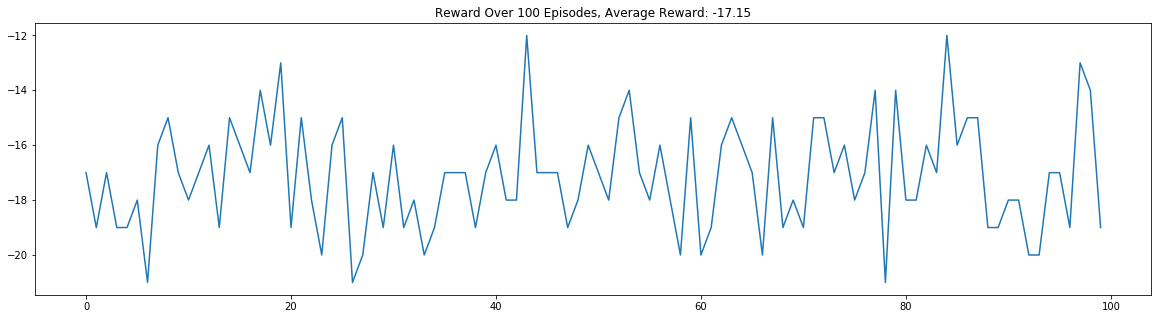

In [4]:
def interpret(number):
    if number == '0':
        return "low"
    return "high"


outfile = open("sasinput.txt","a")
file_2k = open("2k_rem.txt","r")

for i in range(10,15):
    params = list(file_2k.readline())[:4]
    Training(i,outfile,risk=interpret(params[0]),sample_ratio=interpret(params[1]),epsilon_decay=interpret(params[2]),buffer_size=interpret(params[3]))
    

In [57]:
hi = np.load(out_dir_scoring+"rewards_High_High_High_High.npy")

print(hi.shape)

hil = [str(i) + " " for i in np.ndarray.tolist(hi)]
hil

(100,)


['-16.0 ',
 '-17.0 ',
 '-18.0 ',
 '-16.0 ',
 '-17.0 ',
 '-10.0 ',
 '-16.0 ',
 '-18.0 ',
 '-19.0 ',
 '-13.0 ',
 '-18.0 ',
 '-18.0 ',
 '-20.0 ',
 '-14.0 ',
 '-17.0 ',
 '-15.0 ',
 '-17.0 ',
 '-14.0 ',
 '-16.0 ',
 '-17.0 ',
 '-17.0 ',
 '-16.0 ',
 '-19.0 ',
 '-20.0 ',
 '-14.0 ',
 '-15.0 ',
 '-16.0 ',
 '-15.0 ',
 '-17.0 ',
 '-17.0 ',
 '-15.0 ',
 '-18.0 ',
 '-16.0 ',
 '-17.0 ',
 '-18.0 ',
 '-20.0 ',
 '-12.0 ',
 '-17.0 ',
 '-18.0 ',
 '-15.0 ',
 '-18.0 ',
 '-14.0 ',
 '-17.0 ',
 '-16.0 ',
 '-18.0 ',
 '-13.0 ',
 '-18.0 ',
 '-16.0 ',
 '-19.0 ',
 '-18.0 ',
 '-19.0 ',
 '-12.0 ',
 '-17.0 ',
 '-21.0 ',
 '-16.0 ',
 '-13.0 ',
 '-17.0 ',
 '-20.0 ',
 '-19.0 ',
 '-18.0 ',
 '-18.0 ',
 '-16.0 ',
 '-18.0 ',
 '-15.0 ',
 '-20.0 ',
 '-18.0 ',
 '-16.0 ',
 '-14.0 ',
 '-17.0 ',
 '-16.0 ',
 '-16.0 ',
 '-19.0 ',
 '-17.0 ',
 '-18.0 ',
 '-18.0 ',
 '-15.0 ',
 '-14.0 ',
 '-16.0 ',
 '-20.0 ',
 '-19.0 ',
 '-17.0 ',
 '-17.0 ',
 '-16.0 ',
 '-16.0 ',
 '-18.0 ',
 '-17.0 ',
 '-15.0 ',
 '-17.0 ',
 '-14.0 ',
 '-18.0 ',
 '-19.0 ',

In [65]:
def interpret(number):
    if number == 0:
        return "low"
    return "high"

outfile = open("jpsas.txt","a")

for r in range(0,2):
    for s in range(0,2):
        for e in range(0,2):
            for b in range(0,2):
                
                fname = (out_dir_scoring+ "rewards_" + interpret(r) + "_" + interpret(s) + "_" + interpret(e) + "_" + interpret(b))
                data = np.load(out_dir_scoring+ "rewards_" + interpret(r) + "_" + interpret(s) + "_" + interpret(e) + "_" + interpret(b)+".npy")
                print(fname)
                
#                 for i in range(100):
#                     outfile.write(str(r)+ " " + str(s) + " " + str(e) + " " + str(b) + " \n")
outfile.close()

outdir_scoring_rewards/rewards_low_low_low_low
outdir_scoring_rewards/rewards_low_low_low_high
outdir_scoring_rewards/rewards_low_low_high_low


FileNotFoundError: [Errno 2] No such file or directory: 'outdir_scoring_rewards/rewards_low_low_high_high.npy'

In [64]:
np.load(r'outdir_scoring_rewards/rewards_low_low_low_low.npy')

array([-10., -12.,  -9., -15., -12.,  -7., -12., -13.,  -6.,  -8., -13.,
       -12., -14., -12., -17., -17., -14., -13.,  -8., -14., -11., -14.,
       -16., -14., -19., -17.,  -8., -15., -15.,  -9., -12., -13., -18.,
       -17., -11., -12., -13., -10., -12., -17., -11.,  -9., -13., -15.,
       -18., -12., -12., -19., -15., -17., -17., -16., -13., -15., -18.,
       -20., -14.,  -9., -18., -15., -19., -13., -16., -13., -12., -12.,
       -16.,  -9., -15., -10., -15., -14., -14., -14., -12.,  -9., -13.,
       -17., -15., -13., -14.,  -8.,  -6., -10., -14., -15.,  -8., -13.,
       -14., -12., -12., -12., -19., -12., -12., -20., -13., -18., -16.,
       -18.])

In [1]:
for i in range(5,10):
    print(i)

5
6
7
8
9
